# **Deep Learning  - Final Project**

---



**Project Overview**

This project aims to apply advanced deep learning techniques learned during the semester to classify X-ray images. Utilizing the Chest X-ray dataset from Kaggle, we will train and evaluate models, demonstrating the practical application of the techniques acquired from the course.

Download Kaggle Xray Dataset

In [ ]:
!pip install -q kaggle
from google.colab import files

# Create a Kaggle API token and save it to a file.
!echo '{"username":"barelheby","key":"978bdd6cd1cc991c69bbe920fe75a9cc"}' > kaggle.json

# Copy the Kaggle API token file to the correct location.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# Change the permissions of the Kaggle API token file.
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset.
!unzip -q chest-xray-pneumonia.zip

# Print the contents of the current working directory.
!ls


100% 2.29G/2.29G [01:45<00:00, 23.9MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.4MB/s]
autoencoder_2.keras  chest_xray  chest-xray-pneumonia.zip  kaggle.json	sample_data


Imports

In [ ]:
import pandas as pd
from os.path import join
import tensorflow as tf
from keras import Sequential,models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet152
from keras.layers import BatchNormalization,Dropout,Dense,Flatten,UpSampling2D,Conv2D
from tensorflow.keras.optimizers import Adamax,Adam
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.manifold import TSNE
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Constants


In [ ]:
TF_BATCH_SIZE = 32
TF_SEED = 123
IMG_HEIGHT = 256
IMG_WIDTH = 256
DIR_DATASET = "/content/chest_xray"

# Assigment 1 - Binary Classification

---



Data Loading

In [ ]:
train_directory = join(DIR_DATASET,"train")
test_directory = join(DIR_DATASET,"test")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
train_dataset.class_names

['NORMAL', 'PNEUMONIA']

**Model**

In order to get the max feture extruction for this task, We will use *Transfare Learning technique* from VGG16 as the base network for this mission.

In [ ]:
base_network = VGG16(weights="imagenet",include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network.trainable = False
model_assigment_1  = Sequential(name="Assigment_1")
model_assigment_1.add(base_network)
model_assigment_1.add(Flatten())
model_assigment_1.add(Dense(512,activation="relu"))
model_assigment_1.add(Dropout(0.50))
model_assigment_1.add(Dense(128,activation="relu"))
model_assigment_1.add(Dropout(0.25))
model_assigment_1.add(Dense(60,activation="relu"))
model_assigment_1.add(Dense(1,activation="sigmoid"))
model_assigment_1.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=['accuracy'])
model_assigment_1.summary()

Model: "Assigment_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model_assigment_1.fit(train_dataset,
                        epochs= 20,
                        validation_data = validation_dataset,
                        callbacks = early_stopping)

Epoch 1/20
131/131 [==============================] - 63s 419ms/step - loss: 0.3961 - accuracy: 0.8663 - val_loss: 0.1318 - val_accuracy: 0.9540
Epoch 2/20
131/131 [==============================] - 55s 405ms/step - loss: 0.1710 - accuracy: 0.9363 - val_loss: 0.1433 - val_accuracy: 0.9444
Epoch 3/20
131/131 [==============================] - 50s 370ms/step - loss: 0.1569 - accuracy: 0.9387 - val_loss: 0.0939 - val_accuracy: 0.9732
Epoch 4/20
131/131 [==============================] - 52s 384ms/step - loss: 0.1163 - accuracy: 0.9549 - val_loss: 0.0884 - val_accuracy: 0.9693
Epoch 5/20
131/131 [==============================] - 62s 457ms/step - loss: 0.1216 - accuracy: 0.9542 - val_loss: 0.0939 - val_accuracy: 0.9693
Epoch 6/20
131/131 [==============================] - 63s 464ms/step - loss: 0.1027 - accuracy: 0.9588 - val_loss: 0.0800 - val_accuracy: 0.9684
Epoch 7/20
131/131 [==============================] - 55s 398ms/step - loss: 0.0955 - accuracy: 0.9609 - val_loss: 0.0807 - val_ac

Lets review our the training process.

We will divide our review for 2 sections: accuracy and loss.


**Accuracy**

We can see that in each epoch the accuracy will become higher than before.

Same for the training and validation data.
The main part that we should consider is that the accuracy of the train data will not be much more than the validation data.

If this was the case, we should be concered about overfitting.  

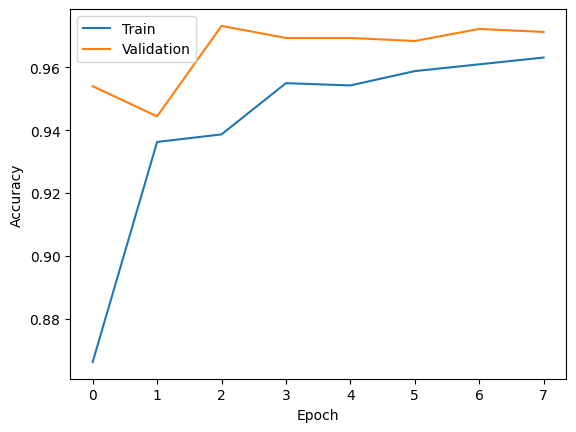

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Loss**

The loss values are getting smaller both training and validation data.

This what we should expect for the same resone as the accuracy.

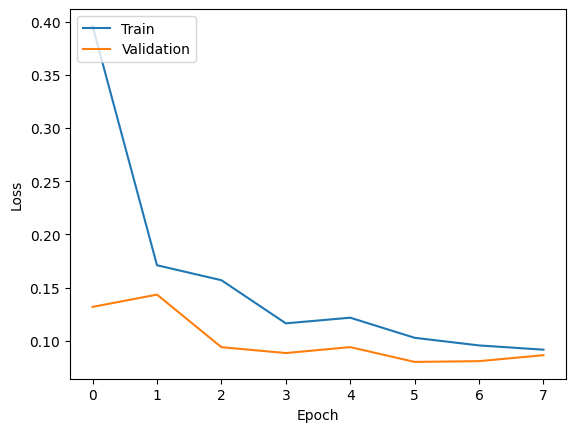

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

After training the model, lets check the performance on the test dataset

In [ ]:
test_loss, test_accuracy = model_assigment_1.evaluate(test_dataset)
print("Test Set  Loss:", test_loss)
print("Test Set Accuracy:", test_accuracy)

20/20 [==============================] - 5s 205ms/step - loss: 0.5685 - accuracy: 0.7804
Test Set  Loss: 0.5685092210769653
Test Set Accuracy: 0.7804487347602844


In [ ]:
model_assigment_1.save("model_assigment_1.keras")

# Assigment 1.2 - Categorial Classification

In [ ]:
DIR_ASS_2 = join(DIR_DATASET,"assiment_2_dataset")
DIR_ASS_2_BACTERIA  = join(DIR_ASS_2,"BACTERIA")
DIR_ASS_2_VIRUS = join(DIR_ASS_2,"VIRUS")
DIR_ASS_2_NORMAL = join(DIR_ASS_2,"NORMAL")

try:
  shutil.rmtree(DIR_ASS_2)
except Exception as e:
  pass
try:
  os.mkdir(DIR_ASS_2)
  os.mkdir(DIR_ASS_2_BACTERIA)
  os.mkdir(DIR_ASS_2_VIRUS)
  os.mkdir(DIR_ASS_2_NORMAL)
except Exception as e:
  pass

Copy Images From Source To New Folder

Copy Sick

In [ ]:
source_dir = join(DIR_DATASET,"train","PNEUMONIA")
for filename in os.listdir(source_dir):
  if "bacteria" in filename.lower():
    dest_dir  = DIR_ASS_2_BACTERIA
  elif "virus" in filename.lower():
    dest_dir = DIR_ASS_2_VIRUS
  else:
    pass
  shutil.copy(join(source_dir,filename),dest_dir)



Copy Normal

In [ ]:
source_dir = join(DIR_DATASET,"train","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),DIR_ASS_2_NORMAL)

Data Loading

In [ ]:
train_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)
validation_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)

Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.


In [ ]:
train_dataset_ass_2.class_names

['BACTERIA', 'NORMAL', 'VIRUS']

**Model**

For this task we will use Transfare learning from ResNet152.

After few attemps, we figure out that this network as the base network provides the best performance for this task.

In [ ]:
base_network_ass_2 = ResNet152(include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network_ass_2.trainable = False
model_assigment_2  = Sequential(name="Assigment_2")
model_assigment_2.add(base_network_ass_2)
model_assigment_2.add(Dense(1024,activation="relu"))
model_assigment_2.add(Dropout(0.3))
model_assigment_2.add(Dense(512,activation="relu"))
model_assigment_2.add(Dropout(0.2))
model_assigment_2.add(Dense(64,activation="relu"))
model_assigment_2.add(Dense(3,activation="softmax"))
model_assigment_2.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_assigment_2.summary()

234698864/234698864 [==============================] - 11s 0us/step
Model: "Assigment_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                     

In [ ]:
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
history_ass_2 = model_assigment_2.fit(train_dataset_ass_2,
                        epochs= 50,
                        validation_data = validation_dataset_ass_2,
                        callbacks = early_stopping)

Epoch 1/50
131/131 [==============================] - 82s 491ms/step - loss: 0.6826 - categorical_accuracy: 0.7076 - val_loss: 0.5121 - val_categorical_accuracy: 0.7843
Epoch 2/50
131/131 [==============================] - 59s 436ms/step - loss: 0.5205 - categorical_accuracy: 0.7838 - val_loss: 0.4810 - val_categorical_accuracy: 0.7996
Epoch 3/50
131/131 [==============================] - 54s 399ms/step - loss: 0.4806 - categorical_accuracy: 0.7925 - val_loss: 0.4701 - val_categorical_accuracy: 0.7967


In [ ]:
plt.plot(history_ass_2.history['accuracy'])
plt.plot(history_ass_2.history['val_categorical_accuracy'])
plt.ylabel('Categorial Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_ass_2.history['loss'])
plt.plot(history_ass_2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
validation_loss, validation_accuracy = model_assigment_2.evaluate(validation_dataset_ass_2)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

33/33 [==============================] - 11s 278ms/step - loss: 0.4606 - categorical_accuracy: 0.8092
Validation Loss: 0.46063411235809326
Validation Accuracy: 0.8092042207717896


In [ ]:
model_assigment_2.save("model_assigment_2.keras")

In [ ]:
model_assigment_2.history.model.weights

**Assigment 2**

---



Train The KNN Classifier Function

In [ ]:
def train_knn_by_model(model,train_data):
  X_train = []
  y_train = []
  for batch, label in train_data:
      X_train.append(model.predict(batch))
      y_train.append(label)
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(X_train, y_train)
  return knn



Function To Classify New Image

In [ ]:
def classify(new_image_path,model,knn_model,class_names,assigment_number):
  new_image = Image.open(new_image_path)
  new_image = new_image.resize((IMG_WIDTH,IMG_HEIGHT))
  new_image_array = np.array(new_image)
  new_image_array = np.expand_dims(new_image_array,axis=0)
  new_image_array = np.expand_dims(new_image_array,axis=-1)
  new_image_array = np.repeat(new_image_array, 3, axis=-1)
  new_image_tensor = tf.convert_to_tensor(new_image_array,tf.float32)
  # Create the embedding vector for the image
  new_image_embedding = model.predict(new_image_tensor)
  print("New Image Embedding",new_image_embedding)
  # Use knn to predict
  y_pred_knn = knn_model.predict(new_image_embedding)
  if assigment_number==1:
    return class_names[y_pred_knn[0]]
  y_pred_knn = y_pred_knn[0]
  for i in range(len(y_pred_knn)):
    if int(y_pred_knn[i])==1:
      return class_names[i]

Predict New Image - Assigment 1.a

---



In [ ]:
knn_model_ass_1 = train_knn_by_model(model_assigment_1,train_dataset)

In [ ]:
ass_1_class_names = ["NORMAL","PNEUMONIA"]
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_1,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_2,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_3 = "/content/chest_xray/test/NORMAL/IM-0043-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))

1/1 [==============================] - 1s 797ms/step
New Image Embedding [[1.]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 19ms/step
New Image Embedding [[0.9999963]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 21ms/step
New Image Embedding [[0.0022994]]
Expected: NORMAL, Got: NORMAL


Predict New Image Using KNN  

In [ ]:
knn_model_ass_2 = train_knn_by_model(model_assigment_2,train_dataset_ass_2)

1/1 [==============================] - 3s 3s/step


In [ ]:
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: BACTERIA, Got:", classify(img_1,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: VIRUS, Got:", classify(img_2,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_3 = "/content/chest_xray/test/NORMAL/IM-0011-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))

1/1 [==============================] - 1s 758ms/step
New Image Embedding [[9.4186515e-01 8.2792945e-07 5.8134109e-02]]
Expected: BACTERIA, Got: BACTERIA
1/1 [==============================] - 0s 32ms/step
New Image Embedding [[0.43717575 0.00318239 0.5596419 ]]
Expected: VIRUS, Got: BACTERIA
1/1 [==============================] - 0s 39ms/step
New Image Embedding [[0.07024615 0.91897994 0.01077389]]
Expected: NORMAL, Got: NORMAL


Create Scatter Plots

In [ ]:
embeddings_1 = model_assigment_1.predict(train_dataset)


131/131 [==============================] - 35s 256ms/step


In [ ]:

tsne_data_1 = TSNE(n_components=1,perplexity=15)
tsne_data_1 = tsne_data_1.fit_transform(embeddings_1)
df_1 = pd.DataFrame(tsne_data_1, columns=["x"])
X_1 = df_1["x"]

y_names_1 = [validation_dataset.class_names[0 if row <0.5 else 1] for row in tsne_data_1]
fig_1 = px.scatter(df_1, color=y_names_1, opacity=0.8)
fig_1.show()


In [ ]:
embeddings_2 = model_assigment_2.predict(train_dataset_ass_2)

131/131 [==============================] - 43s 297ms/step


In [ ]:

tsne_data_2 = TSNE(n_components=3,perplexity=15).fit_transform(embeddings_2)
df = pd.DataFrame(tsne_data_2, columns=["x", "y", "z"])
X = df["x"]
y = df["y"]
z = df["z"]

y_names = [validation_dataset_ass_2.class_names[np.argmax(row)] for row in tsne_data_2]
fig = px.scatter(x=X, y=y,  color=y_names, opacity=0.8)
fig.show()


**Assigment 3**

In [ ]:
source_dir = join(DIR_DATASET,"train","NORMAL")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3","NORMAL"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3 = join(DIR_DATASET,"train_directory_ass_3")

source_dir = join(DIR_DATASET,"train","PNEUMONIA")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3_pneumonia"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3_pneumonia"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3_pneumonia","PNEUMONIA"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3_pneumonia","PNEUMONIA")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3_pneumonia = join(DIR_DATASET,"train_directory_ass_3_pneumonia")

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
autoencoder = Sequential()
autoencoder.add(base_model)

autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
# Output layer
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


In [ ]:
ass_3_train_datagen = ImageDataGenerator(rescale=1./255)
ass_3_train_generator = ass_3_train_datagen.flow_from_directory(
        '/content/chest_xray/train_directory_ass_3',
        target_size=(256, 256),
        batch_size=32,
        class_mode='input')

ass_3_sick_generator = ass_3_train_datagen.flow_from_directory(
        '/content/chest_xray/train_directory_ass_3_pneumonia',
        target_size=(256, 256),
        batch_size=32,
        class_mode='input')

Found 1341 images belonging to 1 classes.
Found 3875 images belonging to 1 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(
        ass_3_train_generator,
        epochs=30,
        callbacks = [early_stopping])

In [ ]:
def get_mse_values(data):
  mse_values = []
  for i in range(len(data)):
    original_images, _ = data.next()
    reconstructed_images = autoencoder.predict(original_images,verbose=0)
    original_images = original_images.reshape(original_images.shape[0], -1)
    reconstructed_images = reconstructed_images.reshape(reconstructed_images.shape[0], -1)
    mse = mean_squared_error(original_images, reconstructed_images)
    mse_values.append(mse)
  return mse_values

Mean: 0.0056245727
Max: 0.006190969


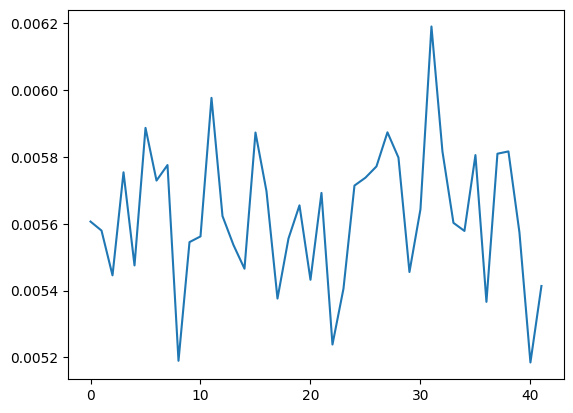

In [ ]:
mse_values_normal = get_mse_values(ass_3_train_generator)
print("Mean:",np.mean(mse_values_normal))
print("Max:",np.max(mse_values_normal))
plt.plot(mse_values_normal)
plt.show()

Mean: 0.016633961
Max: 0.026829662


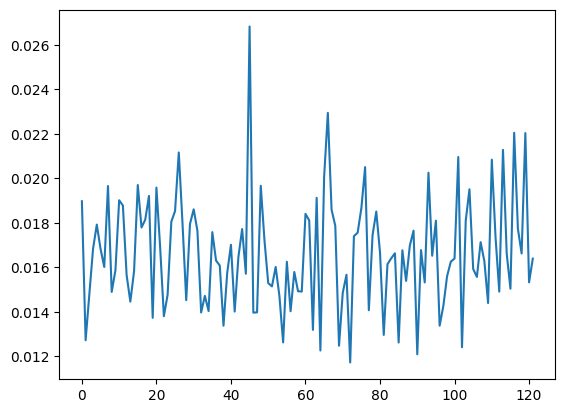

In [ ]:
mse_values_sick = get_mse_values(ass_3_sick_generator)
print("Mean:",np.mean(mse_values_sick))
print("Max:",np.max(mse_values_sick))
plt.plot(mse_values_sick)
plt.show()

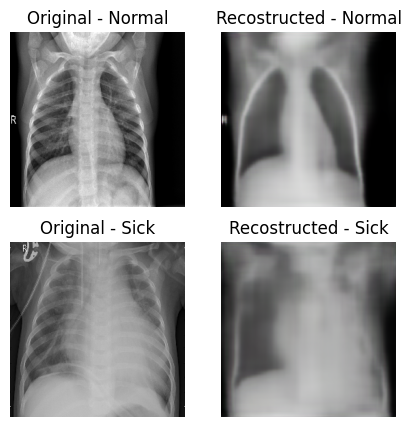

In [ ]:
first_image = np.array(ass_3_train_generator.next()[0][0])
first_image = first_image.reshape((1,) + first_image.shape)
fig, axes = plt.subplots(2, 2,figsize=(5,5))
axes[0][0].imshow(first_image[0])
axes[0][0].set_title("Original - Normal")
axes[0][0].axis("off")
axes[0][1].imshow((autoencoder.predict(first_image,verbose=0)*255).astype('uint8')[0])
axes[0][1].set_title("Recostructed - Normal")
axes[0][1].axis("off")

first_image_sick = np.array(ass_3_sick_generator.next()[0][0])
first_image_sick = first_image_sick.reshape((1,) + first_image_sick.shape)
axes[1][0].imshow(first_image_sick[0])
axes[1][0].set_title("Original - Sick")
axes[1][0].axis("off")
axes[1][1].imshow((autoencoder.predict(first_image_sick,verbose=0)*255).astype('uint8')[0])
axes[1][1].set_title("Recostructed - Sick")
axes[1][1].axis("off")
plt.show()

In [ ]:
autoencoder.save("model_assigment_3.keras")

**Assigment 4 **

---



In [ ]:
def get_image_tensor_from_image_path(image_path):
  new_image = Image.open(image_path)
  new_image = new_image.resize((IMG_WIDTH,IMG_HEIGHT))
  new_image_array = np.array(new_image)
  new_image_array = np.expand_dims(new_image_array,axis=0)
  new_image_array = np.expand_dims(new_image_array,axis=-1)
  new_image_array = np.repeat(new_image_array, 3, axis=-1)
  new_image_tensor = tf.convert_to_tensor(new_image_array,tf.float32)
  new_image_tensor = new_image_tensor.numpy()
  new_image_tensor = np.reshape(new_image_tensor,(IMG_WIDTH,IMG_HEIGHT,-1))/255.0
  return new_image_tensor

In [ ]:
def explain_image(image,actual_classification,prediction_classification):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, lambda x: autoencoder_2.predict(x,verbose=0), top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Predicted - ' + prediction_classification + '\n Ground Truth - ' + actual_classification
             + ' \n Green Regions -> Supporting the predicted label \n Red Regions -> Against the predicted label')
    plt.show()

In [ ]:
imgs = [
    {
        "type":"PNEUMONIA",
        "path":"/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
    },
    {
        "type":"NORMAL",
        "path":"/content/chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg"
    },
    {
        "type":"PNEUMONIA",
        "path":"/content/chest_xray/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg"
    },
    {
        "type":"PNEUMONIA",
        "path":"/content/chest_xray/chest_xray/test/PNEUMONIA/person140_bacteria_668.jpeg"
    }
]

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
autoencoder_2 = load_model('model_assigment_1.keras')
knn_model_ass_1 = train_knn_by_model(autoencoder_2,train_dataset)
ass_1_class_names=["NORMAL","PNEUMONIA"]
# img_path = '/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg'
# img = get_image_tensor_from_image_path(img_path)

NameError: name 'load_model' is not defined

In [ ]:
for obj in imgs:
  tp = obj["type"]
  prediction = classify(obj["path"],autoencoder_2,knn_model_ass_1,ass_1_class_names,1)
  img = get_image_tensor_from_image_path(obj["path"])
  explain_image(img,tp,prediction)